# Foraging Data Acquisition

**Central Theme and Questions:**
I would like to explore the plants in the local Granville area recorded from iNaturalist and collect some interesting data on abundance, medicinal/herbal properties, nutritional value etc by using the Plants For a Future (PFAF).  
I plan to use this data to find some interesting trends about what nutrients are most abundant in native species in Granville, which plants are most observed etc.

**Significance & Context**
This project brings great interest to me especially as sustainability, conservation, and biodiversity are incredibly relevant in the scary reality of the anthropocene. Foraging offers a way to be more mindful about ethical consumption and to connect more deeply with the natural world around you. It's a really cool way to avoid food waste that happens along the food supply chain, help cultivate and sustain native biodiversity. Especially, as it becomes increasingly more difficult to afford nutritious food or to purchase land, foraging is a relatively inexpensive and accessible way to get food.

This project aims create a dataset that links local plant observations in time and space to the plants properties. I will only use a tea dataset from pfaf but the intent is to get an idea of what plants are available to be foraged near me.


In [1]:
#!curl -s -o pfaf_tea.html https://pfaf.org/user/Search_Use.aspx?glossary=Tea

Using curl, I locally downloaded a table of plants that can be used as tea from PFAF from the following link     
https://pfaf.org/user/Search_Use.aspx?glossary=Tea
This data on this page is an aggregate of the larger plant database on the pfaf website. This set includes plants
that are edible are consumable (maybe tasty) when steeped in hot water. The entire 

For my inaturalist data source with local plant observations, I used the following link and copied the outer html into the files inaturalist1.html and inaturalist2.html. 

This website allows users to upload plants / animals they find in their local area and helps identify these observations, while also accumulting data for a very interesting publically available database of local flaura and fauna. 
The files I used are page 1 and page 2 of the inaturalist entries for the Granville area. 
https://www.inaturalist.org/observations?nelat=40.08652602295738&nelng=-82.46661303751478&place_id=any&subview=table&swlat=40.0476648930796&swlng=-82.54048203465203


**Permissions :** 

PFAF : 

- "Plants For A Future (PFAF) is an online free-to-use information database and associated website for those interested in edible and useful plants."

inaturalist: 

- Inaturalist hosts an API as well as an export platform to provide data. When publishing, the data must be cited according to inaturalist's guidlines, however for personal use and projects, inaturalist allows its data to be downloaded.

- "Anyone with an account can export data from iNaturalist as a spreadsheet in csv format. You can start from the Explore page and click download in the lower right of the filters box. Or you can go directly to the export page (https://www.inaturalist.org/observations/export)."


Imports & Data Paths: 

This cell imports the necessary modules from the python libraries and the util module from the textbook.



In [2]:
"""
IMPORTS & DATA PATHS
"""
import os
import io
import sys
import importlib
import pandas as pd
from lxml import etree






module_dir = os.path.join("..", "cs181-s23-student", "modules")
module_path = os.path.abspath(module_dir)
if not module_path in sys.path:
    sys.path.append(module_path)
    
import util
importlib.reload(util)

htmlparser =  etree.HTMLParser()
datadir = "data"



**HTML Parsing**
This function uses etree module's HTML parser to parse the files from the datasources directory 

In [3]:
def htmlParse(filename):
    
    """
    htmlParse 
    params:
    - filename: string file name
    - file must be within "datasource" directory defined above in datadir
    return:
    -returns html root of parsed file
    
    """

    path = os.path.join(datadir, filename)
    tree = etree.parse(path, htmlparser)
    root = tree.getroot()
    
    return root

This function is called to get the html root of all 3 pages

In [4]:

inaturalist_root1 = htmlParse("inaturalist1.html")
inaturalist_root2 = htmlParse("inaturalist2.html")
pfafTea_root = htmlParse("pfaf_tea.html")



# Debugging
#util.print_xml(inaturalist_root2, depth=3, nchild=3)
#util.print_xml(pfafTea_root, depth=3, nchild=3)

This cell is used to find the table root.  
As I used a generic xpath search string, I indexed into the list of nodes returned and hardcoded the index of the node that contained the data.

In [5]:
"""
Finding table root 

"""

s = ".//table"
inatural_table1 = inaturalist_root1.xpath(s)
inatural_table1 = inatural_table1[0]

inatural_table2 = inaturalist_root2.xpath(s)
inatural_table2 = inatural_table2[0]

pfaf_table = pfafTea_root.xpath(s)
pfaf_table = pfaf_table[2]

#Debugging
#util.print_xml(inatural_table1, depth=10, nlines=10)
#util.print_xml(pfaf_table, depth=10, nlines=10)

The function pfafTeaParsing is used to build a dictionary of lists from the pfaf table
Using xpath, the table was parsed column by column. 


In [6]:

def pfafTeaParsing( table_root ):

    """
    Column Parsing - PFAF Tea
    Building DoL

    Table Headers: 
    Latin Name Link,  Common Name, Edibility, Medicinal Properties
    
    params:
    - table_root, root of node that contains a pfaf table 
    return:
     - returns a dictionary of lists containing table data

    """
    DoL = {}
    #Obtains Column Headers
    columns = ['Genus','Species','Common Name', 'Edibility', 'Medicinal']

    # Obtains Latin Name link in column poisition 1

    s = "./tr/td/a[@href]/text()"
    latinName = pfaf_table.xpath(s)
    
    genus = []
    species = []
    
    for item in latinName:
        vals = item.strip().split()
        genus.append(vals[0])
        species.append(vals[-1])
        



    # Obtains column data in column positions 2,3,4 ( Common Name, Edibility, Medicinal Properties)
    s = "./tr/td[position()= {0}]/text()"

    commonName = table_root.xpath(s.format(2))
    edibility = table_root.xpath(s.format(3))
    medicinal = table_root.xpath(s.format(4))
    
    edibility = [int(i) for i in edibility]
    medicinal = [int(i) for i in medicinal]
    

    DoL[columns[0]] = genus
    DoL[columns[1]] = species
    DoL[columns[2]] = commonName
    DoL[columns[3]] = edibility
    DoL[columns[4]] = medicinal
    
    return DoL



The function inaturalParsing is used to build a dictionary of lists from the inatural table root
Using xpath, the table was parsed column by column. 

Below are xpath showing the different cases for commonName and latinName to determine paths to search within


```xml
Display Name: 
    
    
1) Normal Case, Common Name: 
    
<inat-taxon class="split-taxon ng-isolate-scope" taxon="o.taxon" url="/observations/158308895">
    <span class="taxon genus Plantae has-com-name">
        <a class="icon icon-iconic-plantae" href="/observations/158308895" target="_self"></a>
        <a class="noname  ng-hide" href="/observations/158308895" ng-show="!taxon.id" target="_self">Unknown</a>
--->    <a class="display-name comname" href="/observations/158308895" ng-show="taxon.id" target="_self"><span class="rank ng-binding ng-hide" ng-show="(!secondaryName() || user.prefers_scientific_name_first) &amp;&amp; showRank()">Genus<span> </span></span>Lilies of the Valley</a>
        <a class="secondary-name" href="/observations/158308895" ng-show="taxon.id &amp;&amp; secondaryName" target="_self"><span class="comname ng-binding ng-hide" ng-show="user.prefers_scientific_name_first">Convallaria</span><span class="sciname ng-binding" ng-show="!user.prefers_scientific_name_first"><span class="rank ng-binding" ng-show="taxon.preferred_common_name &amp;&amp; showRank()">Genus<span> </span></span>Convallaria</span></a>
    </span>
</inat-taxon>
    
    
    
2) Unknown:
    
<inat-taxon class="split-taxon ng-isolate-scope" taxon="o.taxon" url="/observations/158178210">
    <span class="taxon  Unknown no-com-name">
        <a class="icon icon-iconic-unknown" href="/observations/158178210" target="_self"></a>
--->    <a class="noname display-name" href="/observations/158178210" ng-show="!taxon.id" target="_self">Unknown</a>
        <a class="display-name sciname ng-hide" href="/observations/158178210" ng-show="taxon.id" target="_self"><span class="rank ng-binding ng-hide" ng-show="(!secondaryName() || user.prefers_scientific_name_first) &amp;&amp; showRank()"><span> </span></span></a>
        <a class="secondary-name ng-hide" href="/observations/158178210" ng-show="taxon.id &amp;&amp; secondaryName" target="_self"><span class="comname ng-binding ng-hide" ng-show="user.prefers_scientific_name_first"></span><span class="sciname ng-binding" ng-show="!user.prefers_scientific_name_first"><span class="rank ng-binding ng-hide" ng-show="taxon.preferred_common_name &amp;&amp; showRank()"><span> </span></span></span></a>
    </span>
</inat-taxon>
  

3) No Common Name:
    
<inat-taxon class="split-taxon ng-isolate-scope" taxon="o.taxon" url="/observations/160967828">
    <span class="taxon genus Plantae no-com-name">
        <a class="icon icon-iconic-plantae" href="/observations/160967828" target="_self"></a>
        <a class="noname  ng-hide" href="/observations/160967828" ng-show="!taxon.id" target="_self"> Unknown </a>
--->    <a class="display-name sciname" href="/observations/160967828" ng-show="taxon.id" target="_self">
            <span class="rank ng-binding" ng-show="(!secondaryName() || user.prefers_scientific_name_first) &amp;&amp; showRank()">Genus<span> </span></span>Brunnera</a>
        <a class="secondary-name" href="/observations/160967828" ng-show="taxon.id &amp;&amp; secondaryName" target="_self"><span class="comname ng-binding ng-hide" ng-show="user.prefers_scientific_name_first"></span><span class="sciname ng-binding" ng-show="!user.prefers_scientific_name_first"><span class="rank ng-binding ng-hide" ng-show="taxon.preferred_common_name &amp;&amp; showRank()">Genus<span> </span></span></span></a>
    </span>
</inat-taxon>
    
    

    
Secondary Name: 
    

    
1) Normal, Genus and Species:
    
<a class="secondary-name" href="/observations/160968678" ng-show="taxon.id &amp;&amp; secondaryName" target="_self">
--> <span class="comname ng-binding ng-hide" ng-show="user.prefers_scientific_name_first">Hydrophyllum macrophyllum</span>
--> <span class="sciname ng-binding" ng-show="!user.prefers_scientific_name_first">
        <span class="rank ng-binding ng-hide" ng-show="taxon.preferred_common_name &amp;&amp; showRank()">Species<span> </span>
        </span>
    Hydrophyllum macrophyllum
    </span>
</a>
    
    
2) Only Genus   
    
<a class="secondary-name" href="/observations/160968740" ng-show="taxon.id &amp;&amp; secondaryName" target="_self">
--> <span class="comname ng-binding ng-hide" ng-show="user.prefers_scientific_name_first">Erigeron</span>
--> <span class="sciname ng-binding" ng-show="!user.prefers_scientific_name_first">
        <span class="rank ng-binding" ng-show="taxon.preferred_common_name &amp;&amp; showRank()"> 
            Genus 
            <span> </span> 
        </span>
    Erigeron
    </span>
</a>
    
3) No Common Name, therefore, no secondary Name

4) Unknown, therefore no secondary Name

```


# Issue Encountered : Inaturalist Parsing

This website was much more difficult to parse than pfaf data as there was more metadata and variations in where data was stored depending on what was info was available. Dealing with missing data was the biggest hurdle during this step.

Date and Location were easy as they always had a text value in a specific node so xpath + text() worked easily

Time sometimes contained no text but was stored in the same node for every entry. 
Looping through the nodes and appending NULL where no text was found was the solution to have equal length arrays of data

Common Name and Latin Name were especially tricky because it took careful analysis of all the different possible cases for what fields are available to determine which node to look in. 


**Solution**
Do this procedural with inat-taxon class    
access lower xpath nodes for both comm and latinName    
evaluate with if statements  

latinName = [rank] + sciname

Case 1: Unknown, no display or secondary  
Case 2: No Common Name, display = latin and secondary is empty  
Case 3: Normal, display and latin name are present  

    
a/class="noname display-name" | "noname  ng-hide" --> 1 | 2,3   
a/class="display-name sciname ng-hide"|"display-name sciname|"display-name comname"  --> 1 | 2 | 3
a/class="secondary-name ng-hide" or "secondary-name" --> 1| 2,3  ( if 2, even though node exists, no text)


Pseudo - Code Test ( not correct as I made changes to logic for genus and species ) 
    
    for  node in .//td/inat-taxon

    if unknown with /span class="taxon  Unknown no-com-name"
        then commonName and latinName = "NULL"
    else if a/class = "display-name sciname"
        then commonName = "NULL",
        Rank = /span class="rank ng-binding"/text()
        latinName = /span "display-name sciname"/text()
    else 
        commonName = a/class= "display-name com-name"
        latinName = a/secondary-name/span "rank ng-binding ng-hide"/text()
        Rank = a/secondary-name/span sciname /span"rank ng-binding ng-hide/text()"



In [7]:
def inaturalParsing( table_root ):

    """
    Column Parsing - inaturalist data
    Building DoL

    Table Headers: 

     Date Observed   Time Observed   Location  Common Name  Latin Name

    """
    
    DoL = {}
    
    
    # Obtains Date and Time
    
    s = ".//td[not(@class = 'sorting')]/inat-calendar-date/span[@class = 'date ng-binding']/text()"
    date = table_root.xpath(s)
    
    s = ".//td[not(@class = 'sorting')]/inat-calendar-date/span[@class = 'time ng-binding']"
    timeNodes = table_root.xpath(s)
   
    #Sometimes missing values in this field so loop through nodes to build column
    time = []
    
    for node in timeNodes: 
        if (node.text == None):
            time.append("None")
        else:
            time.append(node.text)
    
    
    # Obtains location
    
    s = ".//td[@class = 'place ng-binding']/text()"
    location = table_root.xpath(s)
    
    
    while '\n' in location:
        location.remove('\n')
    location = [loc.strip() for loc in location]
    
    

    
    
    
    # Obtaining CommonName, Rank, latinName
    
    s = ".//td/inat-taxon"
    nameNode = table_root.xpath(s)
    
    commonName = []
    genus = []
    species = []
    
    
   # util.print_xml(nameNode[0])

    valid = []

    for node in nameNode:
        
        a = "./span[@class = 'taxon  Unknown no-com-name']"  #CASE 1
        b = "./span/a[@class = 'display-name sciname']"      #CASE 2
        c = "./span/a[@class = 'display-name comname']"      #CASE 3
        
        v = node.xpath("./span/@class")[0]
        
        # constructs boolean condition telling if the observation is a plant or fungus
        valid.append(("Plantae" in v) or ('Fungi' in v))
     
        
        if(len(node.xpath(a)) > 0):  
            
            commonName.append(None)          
            genus.append(None)
            species.append(None)
            
        elif(len(node.xpath(b)) > 0):
            
            commonName.append(None)
            
            # Only including names with Genus or Species
            
            r = b + "/span[@class = 'rank ng-binding']/text()"
            rank = node.xpath(r)
            
            l = b + "/text()"
            n = node.xpath(l)[0].strip().split()
            
            if (len(rank) > 0 and rank[0] == 'Species'):
                species.append(n[1])
                genus.append(n[0])
            elif(len(rank) > 0 and rank[0] == 'Genus'):
                species.append(None)
                genus.append(n[0])
                
            else:
                species.append(None)
                genus.append(None)
                
                
        elif(len(node.xpath(c)) > 0):
            
            cc = c + "/text()"
            commonName.append(node.xpath(cc)[0].strip())
            
            
            r = c + "/../a[@class = 'secondary-name']/span[@class = 'sciname ng-binding']/span/text()"
            rank = node.xpath(r)
            
        
            l = c + "/../a[@class = 'secondary-name']/span/text()"
            n = node.xpath(l)[0].strip().split()
            
            if (len(rank) > 0 and rank[0] == 'Species'):
                species.append(n[1])
                genus.append(n[0])
            elif (len(rank) > 0 and rank[0] == 'Genus'):
                species.append(None)
                genus.append(n[0])
                
            else:
                species.append(None)
                genus.append(None)
                
        else:
            
            commonName.append("ERROR")            
            genus.append("ERROR")
            species.append("ERROR")

            

    
    DoL['Date Observed'] = date
    DoL['Time Observed'] = time
    DoL['Location'] = location
    DoL['Common Name'] = commonName
    DoL['Genus'] = genus
    DoL['Species'] = species
    
   
    
    return DoL, valid

In [8]:
"""
getting DoL's and converting to pandas dataframe

concatenate Df1 and Df2 of inaturalist data

"""
teaDoL = pfafTeaParsing(pfaf_table)
inatDoL1, valid1 = inaturalParsing(inatural_table1)
inatDoL2, valid2 = inaturalParsing(inatural_table2)


teaDf = pd.DataFrame(teaDoL, columns= teaDoL.keys())
inatDf1 = pd.DataFrame(inatDoL1, columns=inatDoL1.keys())
inatDf2 = pd.DataFrame(inatDoL2, columns=inatDoL2.keys())


inatDf1 = inatDf1[valid1]
inatDf2 = inatDf2[valid2]

inatDf = pd.concat([inatDf1, inatDf2])



# Additional Info about Datasets

In [9]:
teaDf.head()


,Genus,Species,Common Name,Edibility,Medicinal
0,Abies,amabilis,"Red Fir,Pacific silver fir",1,2
1,Abies,balsamea,Balsam Fir,3,5
2,Abies,fraseri,"She Balsam, Fraser fir, Southern Balsam Fir",1,3
3,Abies,grandis,"Grand Fir, Giant Fir, Lowland White Fir",2,2
4,Abies,lasiocarpa,"Subalpine Fir, Alpine Fir",2,2


**Fields:**  

1) The Edibility rating is a quantitave measure of factors contributing to edibility such as ease of preparation, number of sources found documenting edibie uses. For example, tree bark has a low edibility rating as you cannot really eat and digest treebark as compared to a common weed that people can eat like salad greens, although both can be used for tea.

2) The Medicinal rating is also a similar measure of abundance of medicinal properties. 

3) The (Genus, Species) fields will be used the unique identifier and to link the data in the pfaf and inaturalist datasets

4) Common Name will be provided as additional information for a particular species


Both ratings do not provide much further detail into what are common uses, hazards when ingesting this plant, what parts are edible, what medicinal properties, nutrional value etc, therefore after cutting down my dataset to only include plants that are found in both the pfaf and inaturalist datasets, I plan on using web requests on the href url to provide a little more information on a subsection of these datasets. 

However, I intend to use the ratings to analyse average edibility or most found plants with the highest medicinal properties etc.



Genus and Species will be used as a composite primary key to identify each plant in the tea dataset. 
As this data contains only unique values of plants, the genus and species can be used to uniquely identify the plants common name, edibility, and medicinal properties

I plan on grouping by genus and aggregating some values about edibility and medicinal properties

In [10]:
inatDf.head()

,Date Observed,Time Observed,Location,Common Name,Genus,Species
0,"Apr 28, 2023",1:53 PM EST,"Welsh Hills Rd, Granville, OH, US",Common Blue Violet,Viola,sororia
1,"Apr 28, 2023",12:02 PM EST,Granville,Bitter Wintercress,Barbarea,vulgaris
2,"Apr 28, 2023",11:19 AM EST,Granville,Deer Mushrooms,Pluteus,None
4,April 2023,None,"Ohio, US",Eastern Skunk Cabbage,Symplocarpus,foetidus
5,"Apr 27, 2023",3:33 PM EST,Spring Valley Nature Preserve,Violets,Viola,None



**Fields:**  

1) Date Observed - may use month if SQL Query recognizes that as a date
3) Common Name
4) Genus, Species  

**Database Considerations and Analysis**

For this dataset, the entity observations will have an artificial primary key not in the dataset. 
Especially because time is sometimes not recorded, it is likely that date and location is not enough to uniquely identify a record, although this was a less likely possibility before. 

Similarly, I plan to use to group by Genus and Date to find some aggregates about abundance during a particular time of the year. 

The fields Genus and Species will also be used to inner join with the tea database. As for location and time, I do not have any current plans to use these fields.

# Deliverable #3 : Database Design + Data Storage

One thing that has changed is realizing that the time value may sometimes be null. So for a primary key the combination of date, time, and location will not work. Even before this realization, it is possible ( although unlikely) that 2 observations can be made at the same time, place, and location. 

Thus for the observations part I will have to generate an artificial primary key.


Entites:

- plants ( species ) - I've made plants and species synonymous as I've defined a plant as a plant with both a genus and species 
                     There are some observations with only genus but there is no entry with only a species as the species gives 
                     a higher level of specification *within* genus.

- genus

- observations

A plant/species cannot belong to more than one genus.

For each valid observation, there is always one genus and maybe one species

However for one plant or genus, there may be many observations



**Functional Dependencies**

1) (genname) --> gcomname    ( genus Name --> genus Common Name ) 

2) (genname, species) --> comname, edibility, medicinal, tea

3) (observation id) --> date, time, location, genname, species

The full schema and further discussion of what makes this good database design is provided in the image below

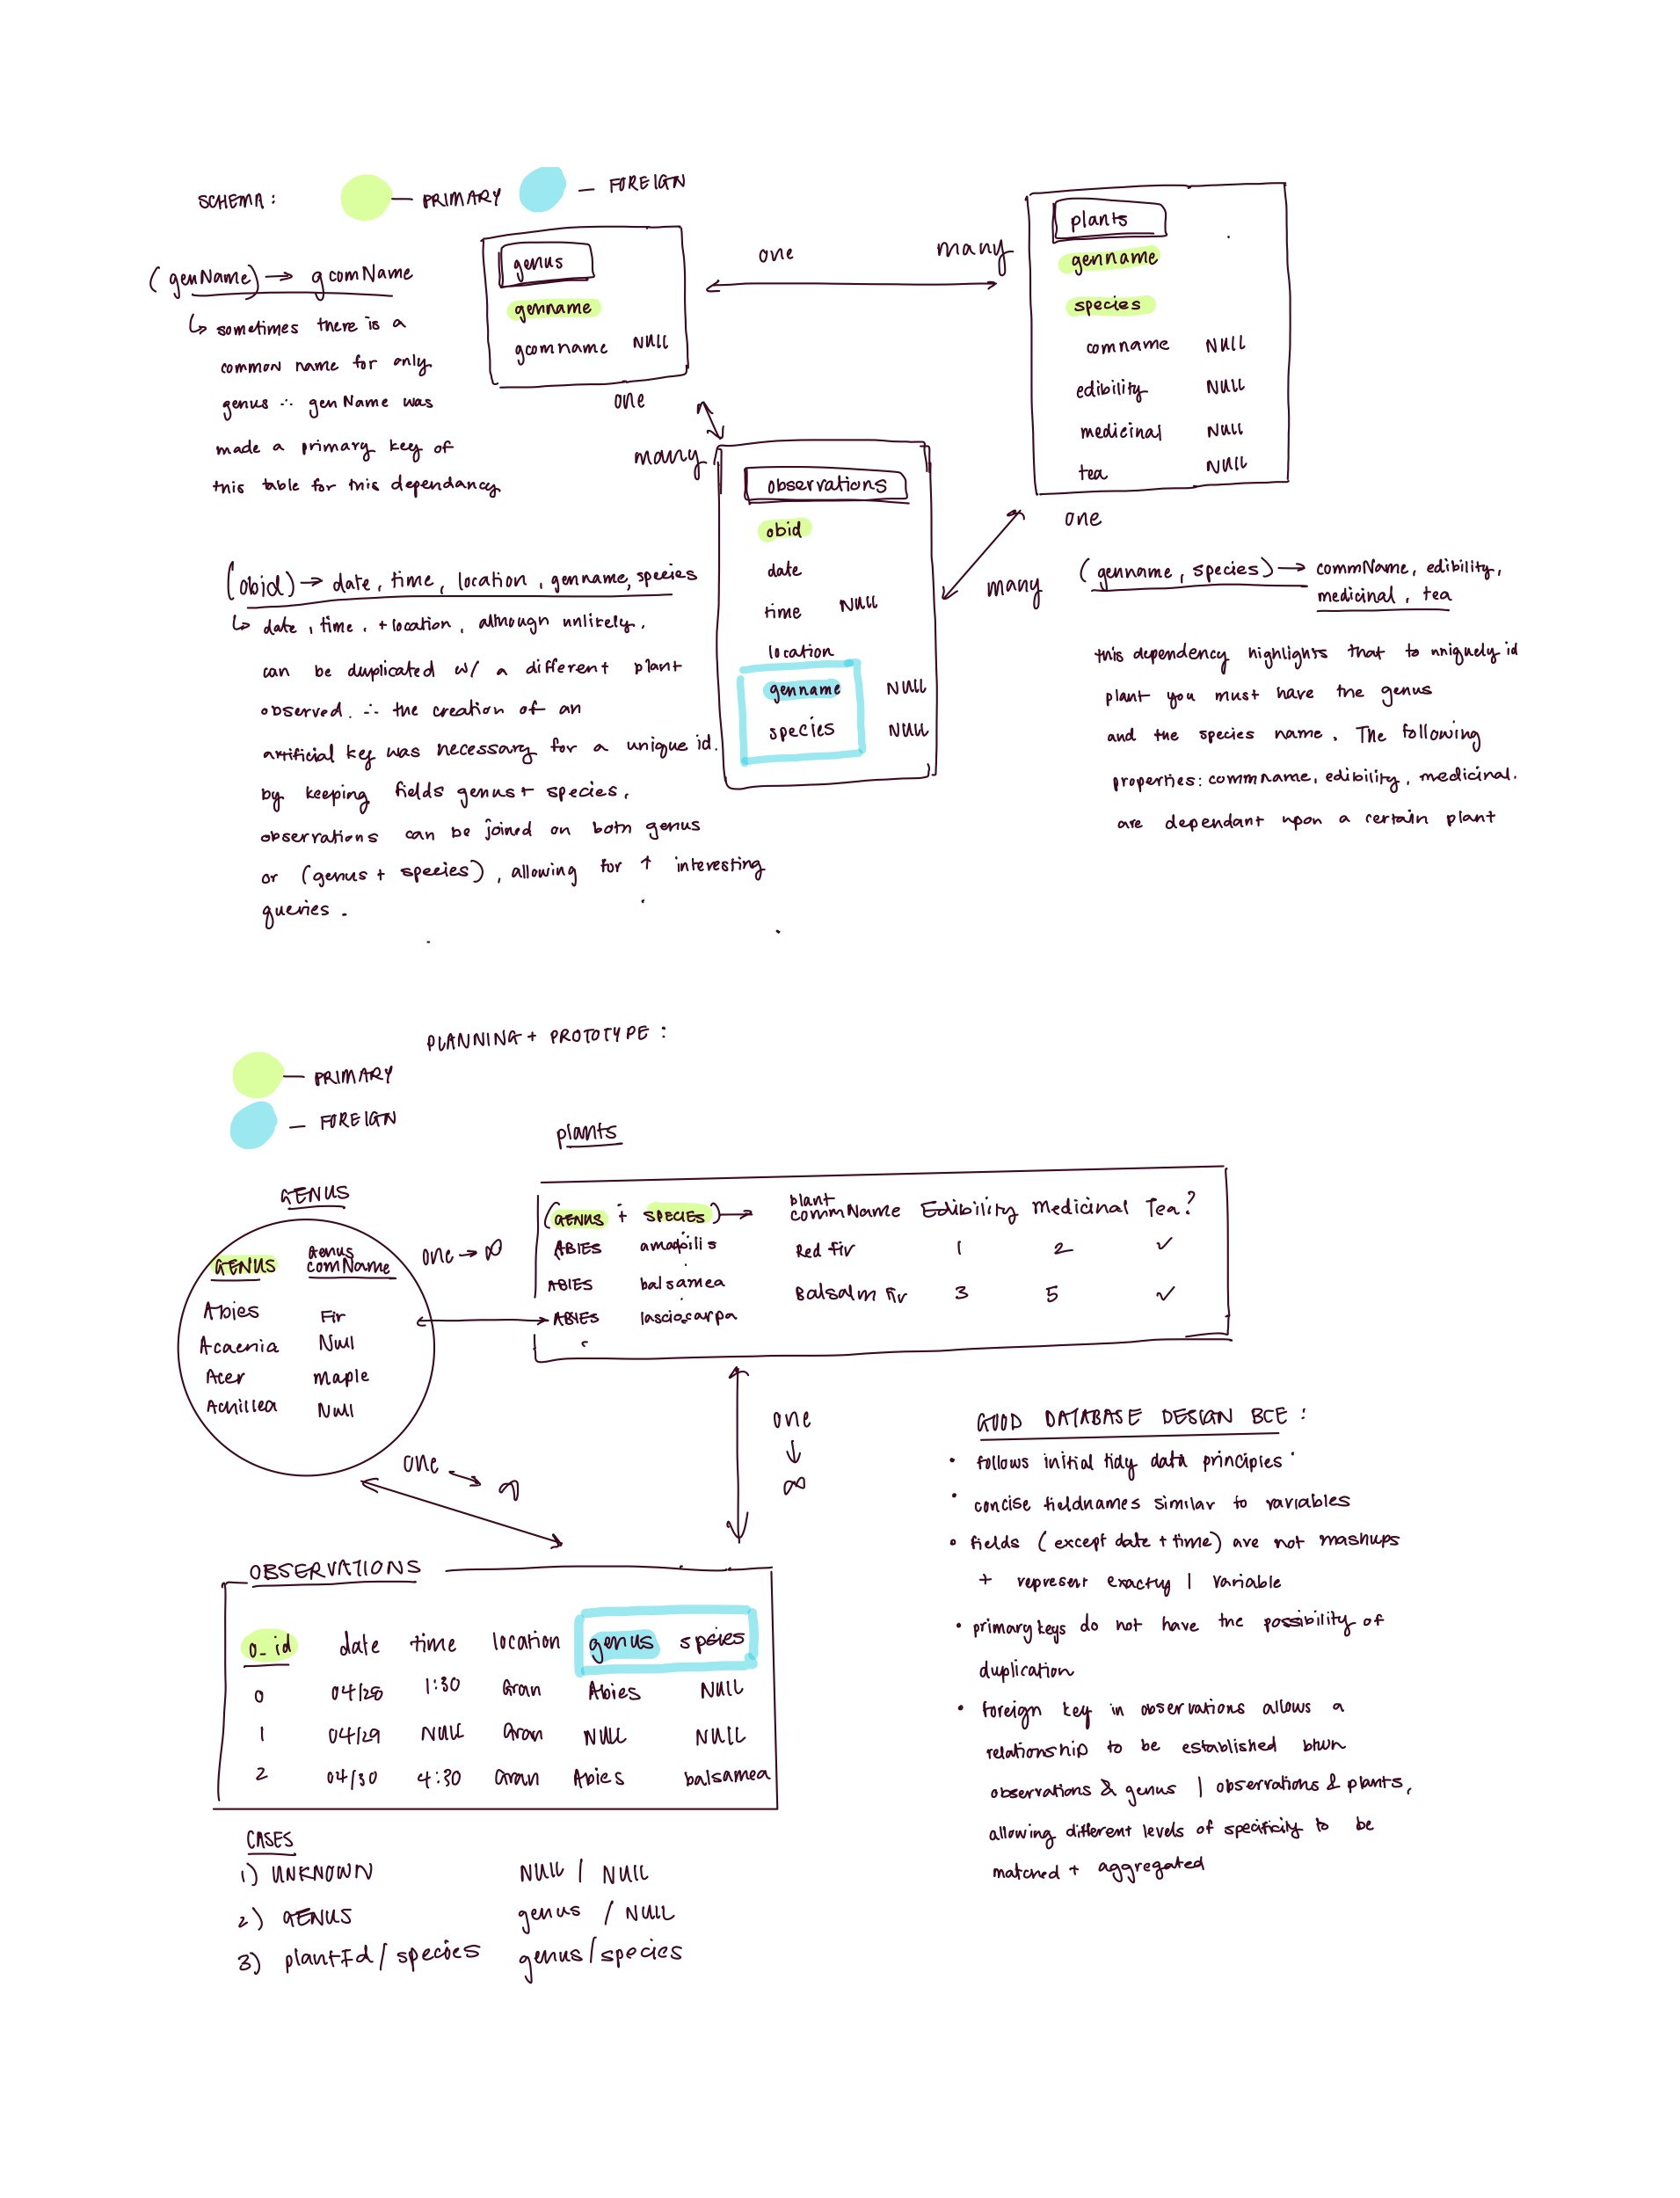

In [10]:
from IPython.display import Image
Image("database_schema.jpg", width=600, height=600)

# Tidy Data / Create Tables based on DB Design

In [11]:
"""
Observations Table

1) Drop Unknown values 

2) Convert current date to a SQL text storage format
    
    DATE – in YYYY-MM-DD format in SQL
(I'm leaving time be) 

"""
observations = inatDf

rdate = observations['Date Observed']

date = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for item in rdate:
    month = ' '
    day =' '
    year = ' '
    vals = item.split(',')
    if (len(vals) < 2):
        vals = vals[0].split()
        month = vals[0][:3]
        year = vals[1]
        day = '01'
    month = vals[0][:3]
    month = str(months.index(month) + 1)
    year = vals[1]
    day = vals[0][4:]
    
    tstring = year + '-'+ month + '-'+ day
    tsring = tstring.replace(" ", "0")
    date.append(tstring)
    
observations = observations.drop('Date Observed', axis = 1)
observations['Date'] = date


observations.shape



(154, 6)

In [12]:
"""
Plants Table
pfaf table is all good 
append list of plants from observations

1) observations with both genus and species, include common Name

2) if duplicates, drop duplicates from observations list

"""

inatplants = observations[['Genus','Species','Common Name']][observations.Species.notna()]
inatplants['Edibility'] = None
inatplants['Medicinal'] = None
inatplants['Tea'] = None

teaDf = teaDf.assign(Tea = "True")
teaDf


plants = pd.concat([teaDf,inatplants])
print(plants.shape)
plants = plants.drop_duplicates(subset = ['Genus','Species']).sort_values(by = ['Genus','Species'])


plants.head()

(779, 6)


,Genus,Species,Common Name,Edibility,Medicinal,Tea
0,Abies,amabilis,"Red Fir,Pacific silver fir",1,2,True
1,Abies,balsamea,Balsam Fir,3,5,True
2,Abies,fraseri,"She Balsam, Fraser fir, Southern Balsam Fir",1,3,True
3,Abies,grandis,"Grand Fir, Giant Fir, Lowland White Fir",2,2,True
4,Abies,lasiocarpa,"Subalpine Fir, Alpine Fir",2,2,True


In [13]:
"""
Genus

using plants table - find all unqiue genuses

add genuses from inat table that don't have a species


"""
inatgenus = observations[['Genus','Common Name']][(observations.Species.isna()) & (observations.Genus.notna())]

inatgenus = inatgenus.drop_duplicates(subset = ['Genus']).sort_values(by = ['Genus'])

plgenus = plants.Genus
      
plname =  plants['Common Name'].apply(lambda x: x.split(' ')[-1])
# best attempt at a genus common name, but not fool proof

plgenus = pd.concat([plgenus,plname],axis=1)

plgenus = plgenus.sort_values(by = ['Common Name']) 
# sorting ensures that those with a common name are first, therefore when the first is dropped, that with a name is prefered
plgenus = plgenus.drop_duplicates(subset = ['Genus']).sort_values(by = ['Genus'])



genus = pd.concat([inatgenus,plgenus])
#.sort_values(by = 'Genus')

genus = genus.drop_duplicates(subset = ['Genus']).sort_values(by = 'Genus').reset_index(drop = True)


print(genus.shape)
print(genus.Genus.nunique())

genus.head()

(348, 2)
348


,Genus,Common Name
0,Abies,Fir
1,Acaenia,Bur
2,Acer,Maple
3,Achillea,Sweet-nancy
4,Acinos,Calamint


# Database Creation

In [14]:
#imports again just in case lol
import pandas as pd
import os
import os.path
import json
import sqlalchemy as sa

In [15]:
""""
SETTING CREDENTIALS FROM LAB 12

"""

def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]



def buildConnectionString(source="sqllite_book"):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)


In [16]:
"""
OPEN CONNECTION
"""

cstring = buildConnectionString(source = "sqlite_foraging")
print("Connection string:", cstring)


engine = sa.create_engine(cstring)
connection = engine.connect()

Connection string: sqlite:///./foraging.db


In [17]:
"""
CREATE genus
"""

# Write the create-table SQL statement
table1 = """CREATE TABLE IF NOT EXISTS genus (
     genname VARCHAR(64) PRIMARY KEY,
     gencomname VARCHAR(64) NULL
     )
"""

# Execute the statement
try:
    connection.execute(table1)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of genus failed:", str(err))

In [18]:
"""
CREATE plants
"""

table2 = """CREATE TABLE IF NOT EXISTS plants (
    genname VARCHAR(64) NOT NULL, 
    species VARCHAR(64) NOT NULL,
    comname VARCHAR(64) NULL,
    edibility INT NULL,
    medicinal INT NULL, 
    tea INT NOT NULL,
    CONSTRAINT pl_plants PRIMARY KEY(genname, species)    
    )
"""

# Execute the statement
try:
    connection.execute(table2)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of plants failed:", str(err))

In [19]:
"""
CREATE observations
"""

table3 = """CREATE TABLE IF NOT EXISTS observations (
    obid INTEGER PRIMARY KEY ASC,
    date VARCHAR(64) NOT NULL, 
    time VARCHAR(64) NULL,
    location VARCHAR(64) NOT NULL,
    genname VARCHAR(64) NULL,
    species VARCHAR(64) NULL,
    comname VARCHAR(64) NULL
    )
"""
# Execute the statement
try:
    connection.execute(table3)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of observations failed:", str(err))

# Populate Database
This portion usees the pandas library that interfaces with sqlalchemy
 
(From Lab 12)


In [20]:
"""
Table 1 - plants

print(len(genus))

"""

headers = {'Genus': 'genname','Species':'species' ,'Common Name': 'comname','Edibility':'edibility', 'Medicinal': 'medicinal', 'Tea': 'tea'}
plants = plants.rename(headers, axis=1)  # Rename to database names

plants.to_sql('plants', con=connection, if_exists="replace", index=False)


738

In [21]:
"""
Table 2 - observations


"""

headers = {'Genus': 'genname','Species':'species' ,'Common Name': 'comname','Time Observed':'time', 'Location': 'location', 'Date': 'date'}
observations = observations.rename(headers, axis=1)  # Rename to database names

observations.to_sql('observations', con=connection, if_exists="replace", index=False)


154

In [23]:
"""
Table 3 - genus

"""
genus = genus.rename({'Genus': 'genname', 'Common Name': 'gencomname'}, axis=1)  # Rename to database names

genus.to_sql('genus', con=connection, if_exists="replace", index=False)


348

In [24]:
# Close the connection!
try:
    connection.close()
except:
    pass
del engine

# Difficultes Faced
1) It was difficult to figure out how to represent missing values
    - moving from pythons objects to dataframes to sqllite it hard to figure out if there is one representation of a missing value that will remain being represented as NaN in pandas and NULL in SQLite. The conclusion I came to was no? Read a lot of stuff about people using numpy.nan though. 
2) SQL Create Table syntax is incredibly specific and was having a tough time getting my statements to execute cleanly. 
   - also realized that there were a lot of ineffiencies in the way I parsed my data as I did so without prior database planning. Just from column names that would have to be changed at the end to adding and dropping and sorting columns to the same table, the way I stored my data in my DoL's ended up playing a much bigger role than I thought.